In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
# Load Data
data = pd.read_csv("product_reviews.csv")
data.head()

,product_id,product_title,category,review_text,rating,sentiment
0,4589130,Stainless Steel Blender,Home & Kitchen,Fast shipping and great packaging.,5,Positive
1,4716121,Long-Wear Matte Lipstick,Beauty,Highly recommend. Excellent quality.,5,Positive
2,9640962,Electric Toothbrush,Health & Personal Care,"Terrible experience, do not buy.",1,Negative
3,4442583,Hydrating Facial Serum,Beauty,"Does the job, but not impressed.",4,Positive
4,9757659,LEGO Building Kit,Toys & Games,Exactly what I needed!,5,Positive


In [4]:
data.shape

(4000000, 6)

In [5]:
data['sentiment'].value_counts()

sentiment
Positive    2063406
Neutral     1231769
Negative     704825
Name: count, dtype: int64

In [6]:
from collections import Counter

# Tokenize all words in the corpus
all_text = " ".join(data['review_text'].astype(str))  # or your text column
words = all_text.split()
word_freq = Counter(words)

# Sort by frequency
most_common_words = word_freq.most_common()
total_words = len(word_freq)

# Analyze coverage
cum_freq = np.cumsum([freq for _, freq in most_common_words])
total_freq = cum_freq[-1]
coverage = cum_freq / total_freq

# Find cutoff where 95%+ of total frequency is covered
for i, c in enumerate(coverage):
    if c > 0.95:
        print(f"To cover 95% of all word occurrences, you need approx. {i+1} tokens.")
        break


To cover 95% of all word occurrences, you need approx. 77 tokens.


In [7]:
data['review_text'].str.split().apply(len).describe()


count    4.000000e+06
mean     4.781139e+00
std      7.737222e-01
min      4.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      7.000000e+00
Name: review_text, dtype: float64

## Split the Dataset into Train_df and Test_df

In [8]:
train_df = data.sample(frac=0.8, random_state=42)
val_df = data.drop(train_df.index)
train_df.to_csv('train2.csv', index=False)
val_df.to_csv('val2.csv', index=False)

In [9]:
df = pd.read_csv("train.csv")
df.shape

(3200000, 6)

### Check for class weights

In [10]:
df['sentiment'].value_counts()

sentiment
Positive    1650428
Neutral      985625
Negative     563947
Name: count, dtype: int64

In [11]:
# class weights
class_counts = [563_947, 985_625, 1_650_428]  # Negative, Neutral, Positive
total = sum(class_counts)
class_weights = {i: total / (3 * count) for i, count in enumerate(class_counts)}


## **Modeling**

### Build a data pipeline that:

Reads data from disk (e.g. from my CSV file in documents).

Splits data into training and validation sets within the pipeline (if possible), or uses separate files for train/test.

Vectorizes and encodes data on the fly.

In [12]:
# Parameters
BATCH_SIZE = 32
# Hyperparameters
MAX_VOCAB = 5000    # always adjusted according to your text
MAX_LEN = 15        # Adjust based on your text length
EMBED_DIM = 256      # Increased from 128
LSTM_UNITS = 128     # Increased from 64
DENSE_UNITS = 256    # Increased from 128

# Path to train CSV file
file_path = 'C:/Users/ich/Documents/train.csv'

# Create a TextVectorization layer and adapt it on your training data
# You need to prepare a small dataset for adapting vectorizer first (e.g., first 100k lines or separate file)
import csv

def extract_text(file_path, num_lines=100000):
    texts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        header = next(reader)  # skip header
        for i, row in enumerate(reader):
            if i >= num_lines:
                break
            review = row[3]  # 4th column, adjust if needed
            texts.append(review)
    return texts

sample_texts = extract_text(file_path)
vectorizer = TextVectorization(max_tokens=MAX_VOCAB, output_mode='int', output_sequence_length=MAX_LEN)
vectorizer.adapt(sample_texts)


In [13]:
REVIEW_COLUMN_INDEX = 3      # column 3 is the review text
SENTIMENT_COLUMN_INDEX = 5   # column 5 is the sentiment

# Sentiment mapping
keys = tf.constant(['Negative', 'Neutral', 'Positive'])
values = tf.constant([0, 1, 2], dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(keys, values)
label_lookup_table = tf.lookup.StaticHashTable(table_init, default_value=-1)

# CSV parsing
record_defaults = [tf.constant('', dtype=tf.string)] * 6  # 6 columns

def parse_line(line):
    fields = tf.io.decode_csv(line, record_defaults)
    review = fields[REVIEW_COLUMN_INDEX]
    label_str = tf.strings.strip(fields[SENTIMENT_COLUMN_INDEX])
    label = label_lookup_table.lookup(label_str)
    review_vector = vectorizer(review)
    return review_vector, label

# Create dataset  pipeline from the CSV file
dataset = tf.data.TextLineDataset(file_path).skip(1)  # Skip header
dataset = dataset.map(parse_line, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.filter(lambda x, y: tf.not_equal(y, -1))  # Filter out invalid labels
dataset = dataset.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


### Build and Compile the Model

In [14]:
model = Sequential([
    # Embedding layer
    layers.Embedding(
        input_dim=MAX_VOCAB, 
        output_dim=EMBED_DIM, 
        input_length=MAX_LEN,
        mask_zero=True  # Efficiently handle padding
    ),
    
    # Stacked Bidirectional LSTMs with LayerNorm
    layers.Bidirectional(layers.LSTM(
        LSTM_UNITS, 
        return_sequences=True,
        kernel_regularizer=regularizers.l2(1e-4)
    )),
    layers.LayerNormalization(),
    
    layers.Bidirectional(layers.LSTM(
        LSTM_UNITS//2,  # Halve units for deeper layer
        kernel_regularizer=regularizers.l2(1e-4)
    )),
    layers.LayerNormalization(),
    
    # Dense layers with increased capacity
    layers.Dense(
        DENSE_UNITS, 
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    ),
    layers.Dropout(0.5),
    
    layers.Dense(
        DENSE_UNITS//2, 
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-4)
    ),
    layers.Dropout(0.3),
    
    # Output layer
    layers.Dense(3, activation='softmax')
])

In [15]:
#compile the model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.002,  # Increased from default 0.001 for large dataset
    clipnorm=1.0          # Prevent exploding gradients
)

#compile the model
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy']
)

### Callbacks

In [16]:
# Setup Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    mode = 'min',  # Lower loss is better
    restore_best_weights = True
)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir = 'logs',
    update_freq = 1000  # Reduce logging frequency for large datasets
)

callbacks = [checkpoint, lr_scheduler, early_stop, tensorboard]


### Load validation dataset

In [17]:
# Path to test CSV file
test_file_path = 'C:/Users/ich/Documents/val.csv'

In [18]:
# test set data pipeline
test_dataset = (
    tf.data.TextLineDataset(test_file_path).skip(1)
    .map(parse_line, num_parallel_calls=tf.data.AUTOTUNE)
    .filter(lambda x, y: tf.not_equal(y, -1))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [19]:
test_dataset = tf.data.TextLineDataset(test_file_path).skip(1)
test_dataset = test_dataset.map(parse_line, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.filter(lambda x, y: tf.not_equal(y, -1))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Train the Model

In [20]:
# Use dataset in model.fit()
history = model.fit(
    dataset,
    validation_data = test_dataset,
    epochs = 20,              # Allow more epochs for large data
    callbacks = callbacks,
    class_weight = class_weights  # From earlier setup
)


Epoch 1/20
 100000/Unknown 9953s 99ms/step - accuracy: 0.8238 - loss: 0.4482

100000/100000 ━━━━━━━━━━━━━━━━━━━━ 10477s 105ms/step - accuracy: 0.8238 - loss: 0.4482 - val_accuracy: 0.8289 - val_loss: 0.4372 - learning_rate: 0.0020
Epoch 2/20
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8156 - loss: 0.4401
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 11055s 111ms/step - accuracy: 0.8156 - loss: 0.4401 - val_accuracy: 0.8289 - val_loss: 0.4403 - learning_rate: 0.0020
Epoch 3/20
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 11531s 115ms/step - accuracy: 0.8256 - loss: 0.4283 - val_accuracy: 0.8289 - val_loss: 0.4310 - learning_rate: 0.0010
Epoch 4/20
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 11771s 118ms/step - accuracy: 0.8218 - loss: 0.4262 - val_accuracy: 0.8289 - val_loss: 0.4298 - learning_rate: 0.0010
Epoch 5/20
100000/100000 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8244 - loss: 0.4250
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100000/100000 ━━━━━━━━━━━━

## Evaluate the Model

In [21]:
# Evaluate the Model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


25000/25000 ━━━━━━━━━━━━━━━━━━━━ 763s 30ms/step - accuracy: 0.8286 - loss: 0.4300
Test Loss: 0.4298
Test Accuracy: 0.8289


In [22]:
#get predictions and true labels

y_true = []
y_pred = []

for batch in test_dataset:
    X_batch, y_batch = batch
    preds = model.predict(X_batch)
    y_true.extend(y_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━

In [25]:
# inspect metrics

In [26]:
import seaborn as sns

labels = ['Negative', 'Neutral', 'Positive']

# Print classification report
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.89      0.84      0.87    140878
     Neutral       0.70      0.77      0.74    246144
    Positive       0.89      0.86      0.88    412978

    accuracy                           0.83    800000
   macro avg       0.83      0.82      0.83    800000
weighted avg       0.83      0.83      0.83    800000



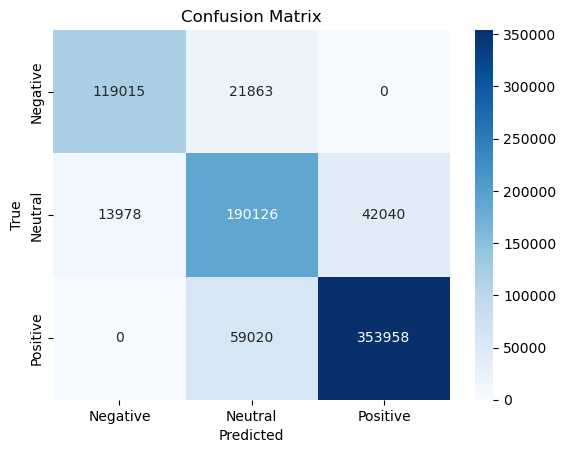

In [27]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

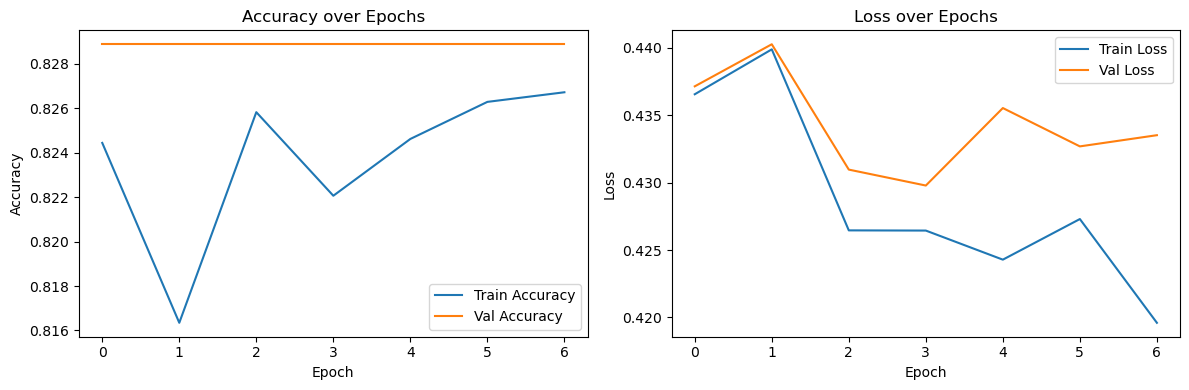

In [30]:
# Plot Training History
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
